In [5]:
import collections
import os
import multiprocessing
print(multiprocessing.cpu_count())
os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm

128


In [3]:
# load data derived from van hateren images (5x5 patches)
with open('data/norm_filtered_5x5.npy', 'rb') as f:
    norm_filtered = np.load(f)

In [8]:
def smooth(x, window_size):
    return np.convolve(x, np.ones(window_size)/window_size, 'valid')

def normalize_frame( W, axis: int = 0):
    """Normalize the columns of W to unit length"""
    W0 = W / np.linalg.norm(W, axis=axis, keepdims=True)
    return W0

def psd_sqrt(C):
    """Computes PSD square root"""
    d, V = np.linalg.eigh(C)
    D_sqrt = np.diag(np.sqrt(np.abs(d)))  # ensure positive eigenvals
    Csqrt = V @ D_sqrt @ V.T
    return Csqrt


def compute_error(C, Ctarget, ord=2):
    return np.linalg.norm(C-Ctarget, ord=ord)


def get_g_opt(
    W,
    Css,
    alpha = 1.0,
):
    """Compute optimal G."""
    N, K = W.shape
    # assert K == N * (N + 1) // 2, "W must have K = N(N+1)/2 columns."
    In = np.eye(N)
    gram_sq_inv = np.linalg.inv((W.T @ W) ** 2)
    Css_12 = psd_sqrt(Css)
    g_opt = gram_sq_inv @ np.diag(W.T @ (Css_12 - alpha*In) @ W)
    return g_opt


def context_adaptation_experiment(
        Css_list,
        N: int,
        K: int,
        eta_w: float,
        eta_g: float,
        batch_size: int,
        n_context_samples: int,
        n_samples: int,
        g0: np.ndarray = None,
        W0: np.ndarray = None,
        alpha=1.,
        online=False,
        normalize_w=False,
        seed=None,
        error_ord=2,
        verbose: bool = True,
        ):
    rng = np.random.default_rng(seed)

    # make sources
    Css12_list = [psd_sqrt(Css) for Css in Css_list]
    n_contexts = len(Css_list)

    if W0 is None:
        W0 = normalize_frame(rng.standard_normal((N, K)))

    N, K = W0.shape
    W = W0.copy()

    In = np.eye(N)

    results = collections.defaultdict(list)

    T = n_contexts if n_context_samples == 0 else n_context_samples
    iterator = tqdm(range(T)) if verbose else range(T)

    if g0 is None:
        g0 = np.median([get_g_opt(W0, C, alpha=alpha) for C in Css_list], 0)
    g = g0.copy()
    # prepend and append the same 10 random contexts for plotting later
    pre_post = rng.integers(0, n_contexts, (10))
    contexts = np.concatenate([pre_post, rng.integers(0, n_contexts, (T-20, ) ), pre_post])
    for t in iterator:
        ctx = contexts[t]
        Css, Css12 = Css_list[ctx],  Css12_list[ctx]

        for _ in range(n_samples):

            if online:
                # draw sample and compute primary neuron steady-state
                s = Css12 @ rng.standard_normal((N, batch_size))  # sample data
                WGWT = (W * g[None, :]) @ W.T  # more efficient way of doing W @ np.diag(g) @ W.T
                M = np.linalg.solve(alpha*In + WGWT, In)  # more stable than inv
                r =  M @ s  # primary neuron steady-state

                # compute interneuron input/output and update g
                z = W.T @ r  # interneuron steady-state input
                n = g[:, None] * z   # interneuron steady-state output
                w_norm = np.linalg.norm(W, axis=0)**2  # weight norm
                dg = z**2 - w_norm[:, None]
                g = g + eta_g * np.mean(dg, -1)

                # update W
                rnT = r @ n.T / batch_size
                dW = rnT - W * g[None, :]
                W = W + eta_w * dW
                Crr = M @ Css @ M.T

            else:
                WG = W * g[None, :]
                WGWT = WG @ W.T  # more efficient way of doing W @ np.diag(g) @ W.T
                M = np.linalg.solve(alpha*In + WGWT, In)  # more stable than inv
                Crr = M @ Css @ M.T

                # update W
                dg = np.diag(W.T@Crr@W - W.T@W)
                dW = Crr @ WG - WG
                g = g + eta_g * dg
                W = W + eta_w * dW

            W = normalize_frame(W) if normalize_w else W
            results['g'].append(g)
            results['g_norm'].append(np.linalg.norm(g))
            results['W_norm'].append(np.linalg.norm(W))
            results['error'].append(compute_error(Crr, In, error_ord))

    results.update({
        'W0': W0,
        'W': W,
        'N': N,
        'K': K,
        'eta_w': eta_w,
        'n_samples': n_samples,
        'g0': g0,
        'W0': W0,
        'seed': seed,
    })
    return results

In [6]:
patch_h, patch_w = 5, 5
N, K =  patch_h*patch_w, patch_h*patch_w
# n_samples = 20_000
n_samples = 50
eta_w = 5E-2
eta_g = 5E-1
seed = 18
data_seed = 18
test_size = .1

alpha = 1.0
batch_size = 100
n_context_samples = 1_000
alpha = 1.0

# run experiment once on real and control contexts
Css_train, Css_test = train_test_split(norm_filtered, test_size=0.2, random_state=data_seed)
g0 = None
W0 = None
online = False
normalize_w = True
model_seed = seed
error_ord = 2
verbose=True

results_train = context_adaptation_experiment(
    Css_train,
    N,
    K,
    eta_w,
    eta_g,
    batch_size,
    n_context_samples,
    n_samples,
    g0,
    W0,
    alpha,
    online=online,
    normalize_w=normalize_w,
    seed=model_seed,
    error_ord=error_ord,
    verbose=verbose,
    )


100%|██████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.59it/s]


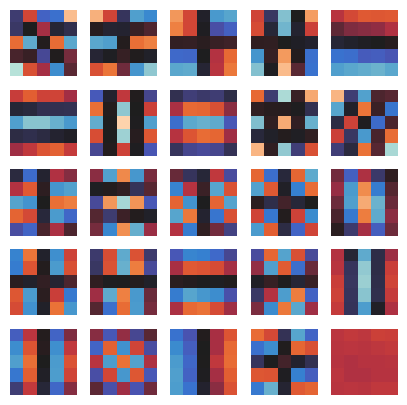

In [7]:
def plot_filters(results, nrows, ncols, figsize, cmap='icefire'):
    # plot all hxw * hxw filters
    W = results['train']['W']
    n2, k = W.shape
    h, w = int(np.sqrt(n2)), int(np.sqrt(n2))
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize, sharex='all', sharey='all')
    ax = ax.ravel()
    MAX = np.max(np.abs(W))
    for i in range(k):
        w0 = W[:, i].reshape((h, w))
        ax[i].imshow(w0, cmap=cmap, vmin=-MAX, vmax=MAX)
        ax[i].axis('off')
    for i in range(k, nrows*ncols):
        ax[i].axis('off')
    sns.despine(bottom=True, left=True)

# plot_filters(results_repeated[18], 5, 5, figsize=(5, 5), cmap='icefire')
plot_filters({ "train": results_train }, 5, 5, figsize=(5, 5), cmap='icefire')

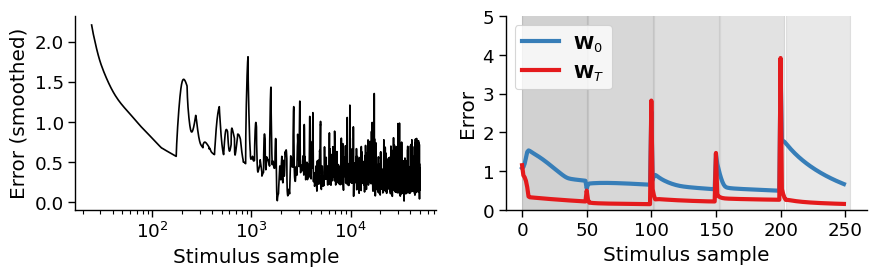

In [9]:
def plot_results(results, dpi):
    # plot error over time

    x = np.linspace(1, n_context_samples+1, len(results['error']))
    n_contexts_to_plot = 10
    T = n_samples*n_contexts_to_plot

    # plot all error
    error = results['error']

    T_smooth = n_samples

    error_smooth = smooth(error, T_smooth)
    xx = np.arange(len(error))
    x_smooth  = smooth(xx, T_smooth)

    with sns.plotting_context('paper', font_scale=1.5):
        fig, ax = plt.subplots(1, 2, figsize=(9, 3), dpi=dpi)
        ax[0].plot(x_smooth, error_smooth, 'k')
        lw = 3

        # plot error at early and late time chunks
        t0 = n_samples
        error = np.array(results['error'])
        error_early = error[5*t0:10*t0]
        error_late = error[-5*t0:]
        cols = sns.color_palette('Set1', 2)
        ax[1].plot(range(len(error_early)), error_early, '-' , markersize=5, color=cols[1], label=r'${\bf W}_0$', lw=lw)
        ax[1].plot(range(len(error_late)), error_late, '-', markersize=5, color=cols[0], label=r'${\bf W}_T$', lw=lw)

        cols = sns.color_palette('gray', 8)[:5]
        from matplotlib.patches import Rectangle
        # plot rectangle patches from (0, 0) to (n_samples, 10)
        # do 5 times in steps of n_samples
        for i in range(5):
            patch = Rectangle((i*t0 + i, 0), t0, 10, color=cols[i], alpha=0.2)
            ax[1].add_patch(patch)

        yscale ='linear'
        ax[0].set(yscale=yscale, xscale='log', xlabel='Stimulus sample', ylabel='Error (smoothed)')
        ax[1].set(yscale=yscale, xlabel='Stimulus sample', ylabel='Error', ylim=(0, 5.))
        ax[1].legend()

        sns.despine()
        fig.tight_layout()


plot_results(results_train, dpi=None)